# Сегментирование входящих данных [0..1] в классы в OHE формате

Проверим выделенные ресурсы для ноутбука

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 12.6 GB | Proc size: 95.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util:   0% | Total: 16280MB
GPU Model: Tesla P100-PCIE-16GB


###Подключим библиотеки

In [ ]:
from tensorflow.keras.models import Model, load_model # модели керас
from tensorflow.keras.layers import Input, Conv2DTranspose, UpSampling2D, concatenate, Activation, Conv2D, MaxPooling2D, BatchNormalization, Maximum, Add # слои
from tensorflow.keras import backend as K # модуль backend кераса
from tensorflow.keras.optimizers import Adam # оптимайзеры 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # колбэки
from tensorflow.keras import utils # утилиты кераса для OHE
from google.colab import files # работа с файлами
import matplotlib.pyplot as plt # работа с графиками
import seaborn as sns # для цветовой палитры
from tensorflow.keras.preprocessing import image # работа с изображениями
import numpy as np # библиотека numpy
from sklearn.model_selection import train_test_split # деление на выборки
import time # библиотека работы с временем
import random # библиотека работы с генератором случайных чисел
import os # библиотека для работы с файловой системов ОС
from PIL import Image # работа с изображениями 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Функции и параметры

In [ ]:
# ДАТАСЕТЫ ЗДЕСЬ
# https://drive.google.com/drive/folders/1_gbYreFimuK0ICO5UIFFCUBWM5Th0OSj?usp=sharing

In [ ]:
# Unpack files
!unzip -q -o '/content/drive/MyDrive/faces1000segmented.zip' -d /content

In [ ]:
# параметры картинки
img_rows  = 256 #176       #352
img_cols  = 256 #240       #480
channels  = 3
img_shape = (img_rows, img_cols, channels)

# расположение папок с файлами
x_dir       = '/content/origin'   # основная выборка
y_dir       = '/content/segment'  # сегментированная выборка

In [ ]:
# сформируем список классов
classes = ['background'] + ['smile'] # фон + названия классов 
num_classes = len(classes) # количество классов (включая пустой класс)
print(classes)

['background', 'smile']


In [ ]:
# список RGB цветов соответствующий классам + черный
rgb_classes = np.array( [[0,0,0]] + [[254,0,0]] )# создаем палитру цветов + черный фон
rgb_classes = rgb_classes.astype('uint8').tolist()  # переведем в uint8
print(rgb_classes)
display(sns.color_palette("hls", num_classes-1))          # палитра для классов которые загружаем и которые размечены

[[0, 0, 0], [254, 0, 0]]


[(0.86, 0.3712, 0.33999999999999997)]

**Функции конвертации и вывода картинок**

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс
def color2index(color, ind):
  index=0 # по умолчанию ноль (background)
  if (color[0]==0)and(color[1]==0)and(color[2]==0) : index=0 # background
  else: index=ind
  return index  

# Функция преобразования OHE индекса в цвет RGB пикселя
def index2color(index2):
  color = [0, 0, 0] # черный по умолчанию (background)
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color = rgb_classes[index] # Цвет берем из заранее подготовленой палитры
  return color # Возвращаем цвет пикслея

# Функция перевода файла в OHE
def rgbToohe(y, ind, num_classes): 
  shape = y.shape # сохраним размерность массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i],ind), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(shape[0], shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

# функция конвертации OHE картинки в RGB картинку
def oheToRGB(img):
  out = [] # пустой список для новой картинки в RGB
  img = img.reshape(-1, num_classes) # решейпим в лист из OHE пикселей
  for i in range(len(img)): # проходим по каждому и меняем OHE на RGB
    out.append(index2color(img[i])) # переводим текущий пиксель в RGB
  out = np.array(out)
  out = out.reshape(img_rows, img_cols, channels) # решейп под обычную картинку
  return out 

# Функция визуализации сегментированных изображений xVal
def processVal(model, count = 5, n_classes = num_classes):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_rows, img_cols, channels))) # Предиктим картинку
    pr = predict[0] # Берем нулевой элемент из предикта
    pr1 = [] # Пустой лист под сегментированную картинку из предикта
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по попиксельно по картинке выровненой вертикально и по горизонтали только OHE цветов
      pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
      pr2.append(index2color(yr[k])) # Переводим индекс в пиксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_rows, img_cols,channels) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_rows, img_cols,channels) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    xv = (xVal[idx]*255).astype('uint8') # скалируем картинку обратно для вывода
    axs[2,i].imshow(Image.fromarray(xv)) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

### (!) Подготовим выборки
Длительный процесс

In [ ]:
# # общая база X и Y
# X = []
# Y = []
# cur_time = time.time() # засекаем время

# # проходим по файлам папки текущего класса (исходной и сегментированой сразу)
# for x_filename, y_filename in zip(
#                                   sorted(os.listdir(x_dir)),
#                                   sorted(os.listdir(y_dir)),
#                                   ):
#   # исходная картинка (массив RGB)
#   x = np.array( image.load_img(x_dir+'/'+x_filename, target_size=(img_rows,img_cols)) )
#   X.append(x) # добавим очередной X
#   # сегментированная картинка (массив RGB)
#   y = np.array( image.load_img(y_dir+'/'+y_filename, target_size=(img_rows,img_cols)) )
#   y_ohe = rgbToohe(y, 1, num_classes) # конвертируем в OHE
#   Y.append(y_ohe) # добавим очередной Y в формате OHE
#   # каждые 100 шагов
#   if len(Y) % 100 == 0: 
#     print('Обработано сэмплов:', len(Y)) # выводим количество обработанных изображений

# # преобразуем в numpy массивы
# X  = np.array(X, dtype='uint8')
# Y  = np.array(Y, dtype='uint8')

# print()
# print('Загрузка файлов завершена: ', round(time.time()-cur_time,2), 'c', sep='')
# print('X.shape', X.shape)
# print('Y.shape', Y.shape)

In [ ]:
# сохраним обработанные данные
# np.save('/content/drive/MyDrive/X-Сегментация_улыбок.npy', X)
# np.save('/content/drive/MyDrive/Y-Сегментация_улыбок.npy', Y)

### Загрузим подготовленные данные

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

264

In [ ]:
# загрузим обработанные данные
X = np.load('/content/drive/MyDrive/X-Сегментация_улыбок.npy')
X = X.astype('float32')/255 # Трансформируем значения в диапазон [0..1] для модели
Y = np.load('/content/drive/MyDrive/Y-Сегментация_улыбок.npy') 
print('XMin:', np.min(X), 'XMax:', np.max(X))
print(X.dtype)
print('YMin:', np.min(Y), 'YMax:', np.max(Y))
print(Y.dtype)

XMin: 0.0 XMax: 1.0
float32
YMin: 0 YMax: 1
uint8


In [ ]:
# подготовим выборки
xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size=0.1)
print('xTrain.shape', xTrain.shape)
print('yTrain.shape', yTrain.shape)
print('xVal.shape', xVal.shape)
print('yVal.shape', yVal.shape)

xTrain.shape (900, 256, 256, 3)
yTrain.shape (900, 256, 256, 2)
xVal.shape (100, 256, 256, 3)
yVal.shape (100, 256, 256, 2)


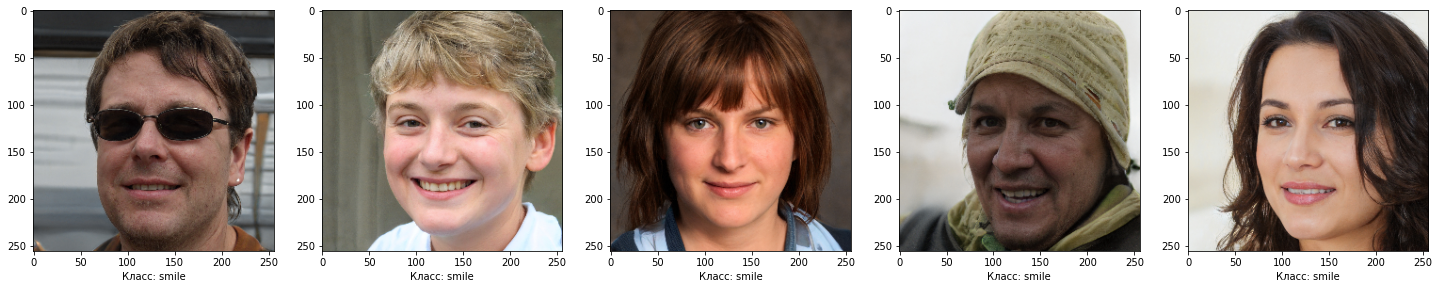

In [ ]:
# вывод случайных исходных картинок
n = 5
idxs = np.random.randint(0,xTrain.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводи в цикле n картинок
  img_arr = xTrain[idx] # картинка
  img_arr = (img_arr*255).astype('uint8') # скалируем картинку обратно для вывода
  axs[i].imshow(Image.fromarray(img_arr)) # рисуем картинку
  # извлечем класс этой картинки
  idx_arr = np.argmax(yTrain[idx],axis=2).flatten()                             # получим из массива картинки только индексы пикселей
  idx_dict = {i:np.where(idx_arr==i)[0].shape[0] for i in range(1,num_classes)} # создадим словарь частотности каждого индекса (исключая черный - 0)
  idx_class = sorted(idx_dict.items(), key=lambda k:k[1], reverse=True)[0][0]   # какого класса больше: результат сортировки список, берем нулевой кортеж, в нем нулевой элемент это наш самый частый индекс
  #
  # axs[i].axis('off') # Отключаем печать названия осей
  axs[i].set_xlabel(f'Класс: {classes[idx_class]}')
plt.show() # вывод холста

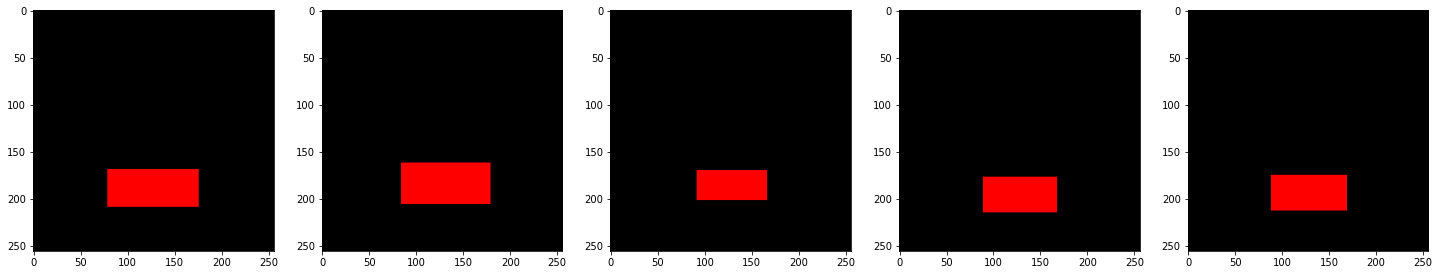

In [ ]:
# вывод случайных сегментированных картинок
n = 5
# idxs = np.random.randint(0,xTrain.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводи в цикле n картинок
  img_ohe = yTrain[idx] # картинка в OHE
  img_rgb = oheToRGB(img_ohe).astype('uint8') # картинка в RGB
  axs[i].imshow(Image.fromarray(img_rgb)) # рисуем картинку
plt.show() # вывод холста

### Гиперпараметры

In [ ]:
# колбэки # .hdf5
checkpoint = [
             ModelCheckpoint('/content/drive/MyDrive/Сегментация_улыбок.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early     = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, mode='auto')

learning_rate = 1e-3 # шаг обучения
batch_size    = 16   # размер batch_size  

# функция метрики
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

### Функция создания модели

#### модель UNET 4 каскада вниз и 4 вверх

In [ ]:
# '''
#   Функция создания сети
#     Входные параметры:
#     - num_classes - количество классов
#     - input_shape - размерность карты сегментации
# '''
# def unet(num_classes = num_classes, input_shape= (img_rows, img_cols, channels)): 
#     img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

#     # Block 1 
#     x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (256 x 256)
#     block_1_out1= Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

#     x = MaxPooling2D()(block_1_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 2 
#     x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (128 x 128)
#     block_2_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_2_out

#     x = MaxPooling2D()(block_2_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 3 
#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (64 x 64)
#     block_3_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_3_out

#     x = MaxPooling2D()(block_3_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 4 - Bottom Line
#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (32 x 32)
#     block_4_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_4_out
#     x = block_4_out1 

#     # UP to 3
#     x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # (64 x 64)
#     x = concatenate([x, block_3_out1])                                      # Объединем текущий слой со слоем block_3_out
#     x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # UP to 2
#     x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # (128 x 128)
#     x = concatenate([x, block_2_out1])                                      # Объединем текущий слой со слоем block_2_out
#     x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     # UP to 1
#     x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     # (256 x 256)
#     x = concatenate([x, block_1_out1])  # Объединем текущий слой со слоем block_1_out
#     x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

#     model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

#     # Компилируем модель 
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=[dice_coef])
    
#     return model # Возвращаем сформированную модель

#### Модель UNET 6 каскадов вниз и 6 вверх

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(input_shape=(img_rows, img_cols, channels)): 
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1 
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (256 x 256)
    x = MaxPooling2D()(block_1_out1)  # (256 x 256) ->  (128 x 128)        # Добавляем слой MaxPooling2D

    # Block 2 
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (128 x 128)
    x = MaxPooling2D()(block_2_out1) # (128 x 128) -> (64 x 64)            # Добавляем слой MaxPooling2D

    # Block 3 
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (64 x 64)
    x = MaxPooling2D()(block_3_out1)  # (64 x 64) -> (32 x 32)             # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (32 x 32)
    x = MaxPooling2D()(block_4_out1)  # (32 x 32) -> (16 x 16)             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)        # Добавляем Conv2D-слой с 1024-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_5_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (16 x 16)
    x = MaxPooling2D()(block_5_out1)  # (16 x 16) -> (8 x 8)               # Добавляем слой MaxPooling2D

    # Block 6 - Bottom line
    x = Conv2D(2048, (3, 3), padding='same', name='block6_conv1')(x)        # Добавляем Conv2D-слой с 2048-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_6_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (8 x 8)
    x = block_6_out1 

    # UP to 5 # (8 x 8) -> (16 x 16)  
    x = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 1024 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (16 x 16)
    x = concatenate([x, block_5_out1])                                      # Объединем текущий слой со слоем block_5_out
    x = Conv2D(1024, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 4 # (16 x 16) -> (32 x 32)  
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (32 x 32)
    x = concatenate([x, block_4_out1])                                      # Объединем текущий слой со слоем block_4_out
    x = Conv2D(512, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 3 # (32 x 32) -> (64 x 64)
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (64 x 64)
    x = concatenate([x, block_3_out1])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 2 # (64 x 64) -> (128 x 128)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (128 x 128)
    x = concatenate([x, block_2_out1])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 1 # (128 x 128) -> (256 x 256)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # (256 x 256)
    x = concatenate([x, block_1_out1])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

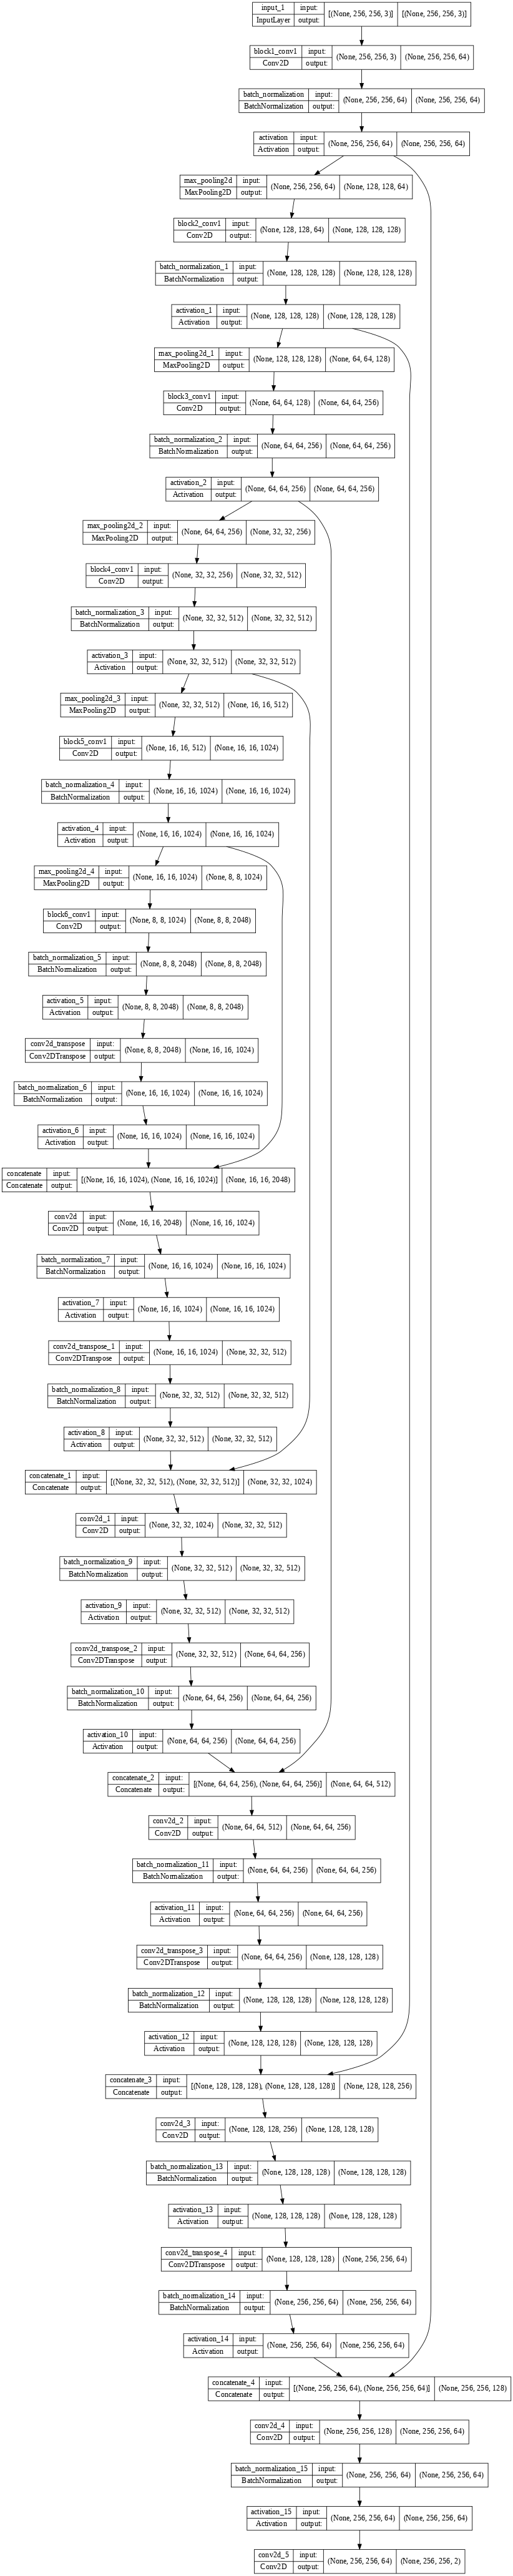

In [ ]:
learning_rate = 1e-3 # шаг обучения
batch_size    = 16   # размер batch_size  

model = unet()                                    # создание модели

model.summary()
utils.plot_model(model, dpi=60, show_shapes=True) # схема модели

### Обучение модели

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

29732

In [ ]:
learning_rate = 1e-3 # шаг обучения
batch_size    = 16   # размер batch_size  

# Компилируем модель 
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
# обучение модели
history = model.fit(xTrain, 
                    yTrain, 
                    epochs = 100,
                    batch_size = batch_size,
                    validation_data = (xVal, yVal),
                    verbose = 1,
                    callbacks=[
                                checkpoint,
                                early,
                                #lr_reduce,
                                ])


Epoch 1/100
57/57 [==============================] - 56s 730ms/step - loss: 0.1688 - dice_coef: 0.9014 - val_loss: 0.7390 - val_dice_coef: 0.5833
Epoch 2/100
57/57 [==============================] - 22s 382ms/step - loss: 0.0382 - dice_coef: 0.9775 - val_loss: 0.2252 - val_dice_coef: 0.8791
Epoch 3/100
57/57 [==============================] - 22s 381ms/step - loss: 0.0288 - dice_coef: 0.9826 - val_loss: 0.1227 - val_dice_coef: 0.9474
Epoch 4/100
57/57 [==============================] - 19s 326ms/step - loss: 0.0266 - dice_coef: 0.9837 - val_loss: 0.2876 - val_dice_coef: 0.9431
Epoch 5/100
57/57 [==============================] - 19s 326ms/step - loss: 0.0263 - dice_coef: 0.9840 - val_loss: 0.1350 - val_dice_coef: 0.9545
Epoch 6/100
57/57 [==============================] - 26s 460ms/step - loss: 0.0260 - dice_coef: 0.9844 - val_loss: 0.0445 - val_dice_coef: 0.9745
Epoch 7/100
57/57 [==============================] - 19s 328ms/step - loss: 0.0249 - dice_coef: 0.9846 - val_loss: 0.0599 - 

In [ ]:
# Загрузить последние веса
model.load_weights('/content/drive/MyDrive/Сегментация_улыбок.h5')
# model = load_model('/content/drive/MyDrive/Сегментация_улыбок.h5', compile = False) # для продакшена compile = False, иначе нужны все остальные функции для модели

In [ ]:
# Дообучение модели

learning_rate = 1e-6 # шаг обучения
batch_size    = 16   # размер batch_size  

# Компилируем модель 
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
# обучение модели
history = model.fit(xTrain, 
                    yTrain, 
                    epochs = 100,
                    batch_size = batch_size,
                    validation_data = (xVal, yVal),
                    verbose = 1,
                    callbacks=[
                                checkpoint,
                                early,
                                #lr_reduce,
                                ])


Epoch 1/100
57/57 [==============================] - 27s 438ms/step - loss: 0.0219 - dice_coef: 0.9864 - val_loss: 0.0282 - val_dice_coef: 0.9853
Epoch 2/100
57/57 [==============================] - 22s 381ms/step - loss: 0.0216 - dice_coef: 0.9864 - val_loss: 0.0273 - val_dice_coef: 0.9854
Epoch 3/100
57/57 [==============================] - 22s 396ms/step - loss: 0.0215 - dice_coef: 0.9866 - val_loss: 0.0271 - val_dice_coef: 0.9854
Epoch 4/100
57/57 [==============================] - 22s 393ms/step - loss: 0.0214 - dice_coef: 0.9866 - val_loss: 0.0270 - val_dice_coef: 0.9854
Epoch 5/100
57/57 [==============================] - 22s 382ms/step - loss: 0.0212 - dice_coef: 0.9866 - val_loss: 0.0270 - val_dice_coef: 0.9854
Epoch 6/100
57/57 [==============================] - 18s 323ms/step - loss: 0.0211 - dice_coef: 0.9867 - val_loss: 0.0270 - val_dice_coef: 0.9854
Epoch 7/100
57/57 [==============================] - 18s 322ms/step - loss: 0.0210 - dice_coef: 0.9867 - val_loss: 0.0270 - 

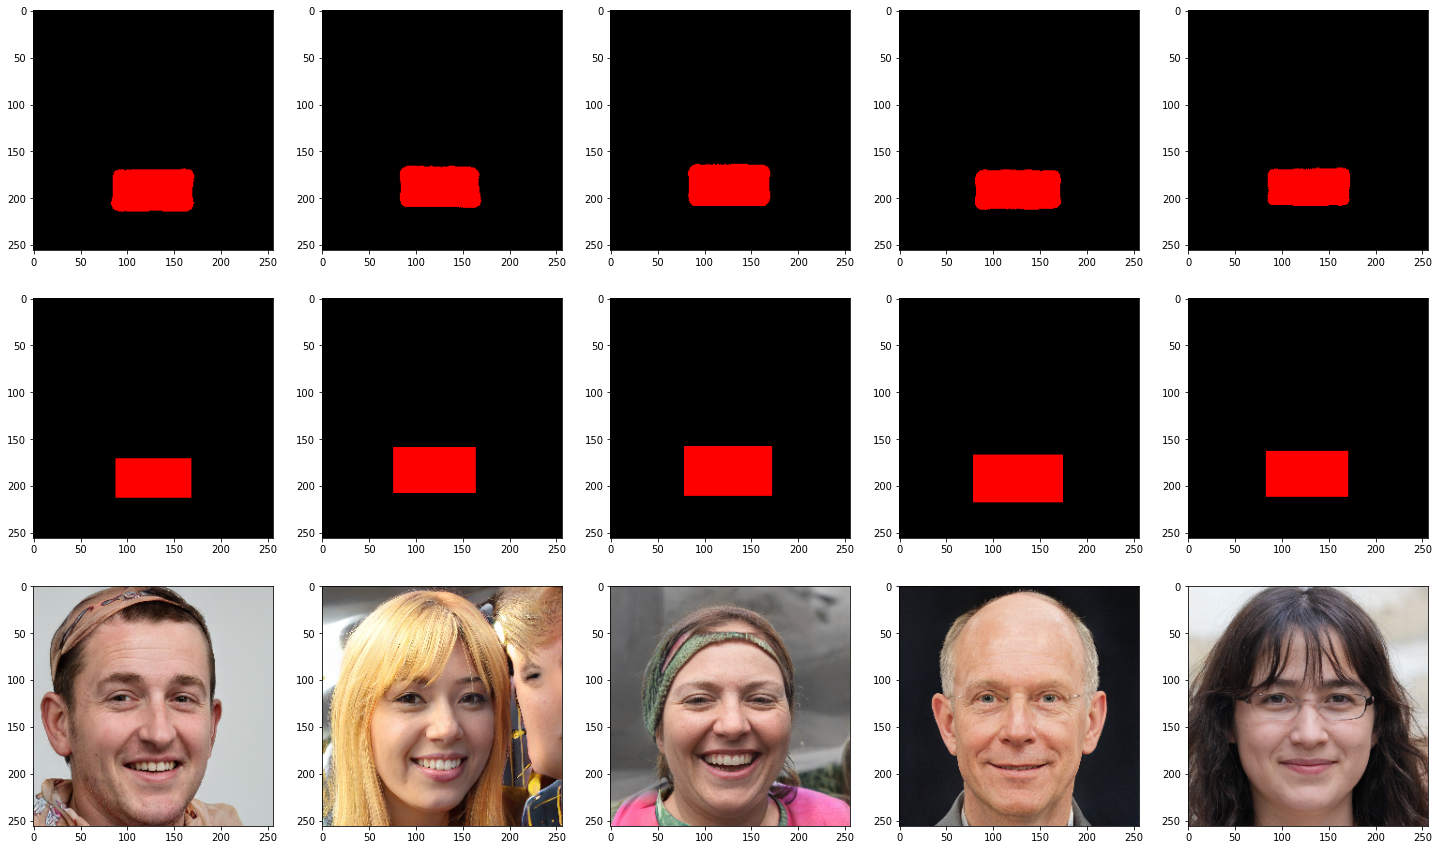

In [ ]:
# выберем для предикта 5 картинок валидационной выборки
processVal(model)

### Наложение маски

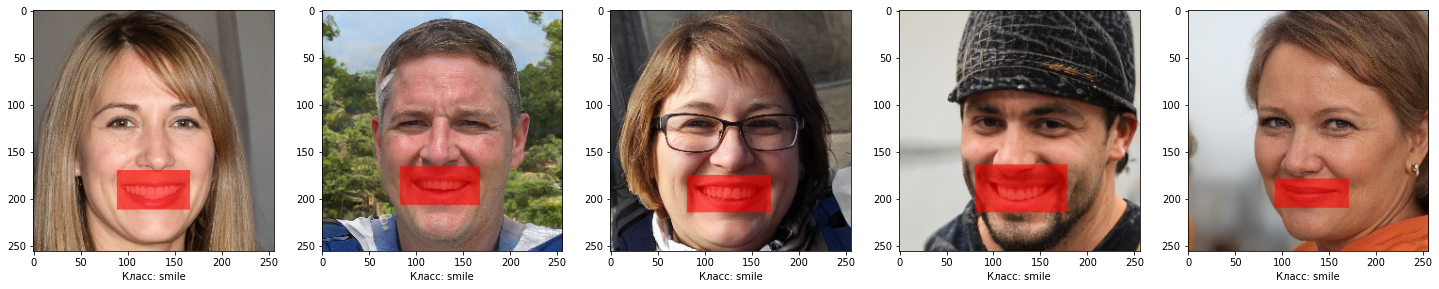

In [ ]:
# вывод картинок из валидационной выборки с маской
n = 5
idxs = np.random.randint(0,xVal.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводи в цикле n картинок
  # формируем маску
  img_ohe = yVal[idx] # картинка в OHE
  img_rgb = oheToRGB(img_ohe) # картинка в RGB
  seg = Image.fromarray(img_rgb.astype('uint8')).convert('RGBA') # сегментированная картинка для маски
  # найдем наиболее частый индекс в картинке предикта
  idx_arr = np.argmax(yVal[idx],axis=2).flatten()                                     # получим из массива картинки только индексы пикселей
  idx_dict = {i:np.where(idx_arr==i)[0].shape[0] for i in range(1,num_classes)} # создадим словарь частотности каждого индекса (ичключая черный - 0)
  idx_class = sorted(idx_dict.items(), key=lambda k:k[1], reverse=True)[0][0]   # какого класса больше: результат сортировки список, берем нулевой кортеж, в нем нулевой элемент это наш самый частый индекс
  #
  mask = np.array(seg) # переведем RGBA маску в numpy массив
  mask[mask[:,:,0]==0] = rgb_classes[0] + [0] # все черные пиксели оставим черными
  mask[mask[:,:,0]!=0] = rgb_classes[idx_class] + [150] # оставим цвет класса + альфа канал 150
  img_mask = Image.fromarray(mask).convert('RGBA') # маска в RGBA
  # загрузим исходную картинку под маску
  xv = (xVal[idx]*255).astype('uint8') # скалируем картинку обратно для вывода
  img_main = Image.fromarray(xv)
  img_main.paste(img_mask, (0,0), img_mask)
  axs[i].imshow(img_main) # выводим очередную картинку с нанесенной маской
  # axs[i].axis('off') # Отключаем печать названия осей
  axs[i].set_xlabel(f'Класс: {classes[idx_class]}')
plt.show() # вывод холста

### Оценим точность модели

In [ ]:
# оценить точность модели
scores = model.evaluate(xVal, yVal, verbose=0)
print('Точность модели: {:.2%}'.format(scores[1]))

Точность модели: 98.58%


### Попробуем распознать картинку из файла

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

67850

In [ ]:
# Загрузить последние веса
# model.load_weights('/content/drive/MyDrive/Сегментация_улыбок.h5')
model = load_model('/content/drive/MyDrive/Сегментация_улыбок.h5', compile = False) # для продакшена compile = False, иначе нужны все остальные функции для модели

In [ ]:
# Компилируем модель 
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[dice_coef])

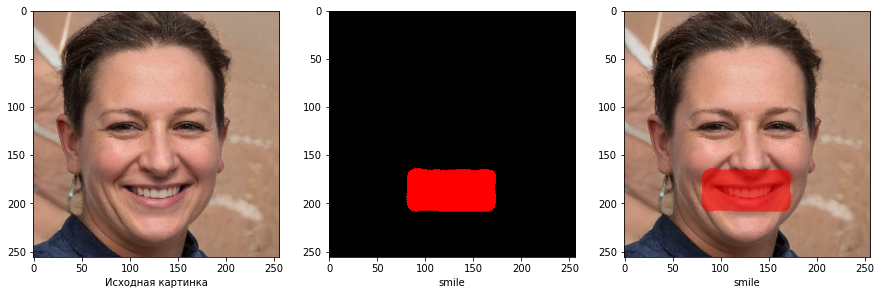

In [ ]:
filename = '/content/origin/0.jpg'
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) #Создаем полотно из 3 графиков
x = np.array( image.load_img(filename, target_size=(img_rows,img_cols)), dtype='uint8' ) # загружаем файл
axs[0].imshow(Image.fromarray(x.astype('uint8')).convert('RGBA')) # выводим исходную картинку 
axs[0].set_xlabel(f'Исходная картинка') # подпишем класс
x = (x/255).astype('float32') # Трансформируем значения в диапазон [0..1] для модели
x = x.reshape(1, img_rows, img_cols, channels) # решейпим в формат для предикта
pr = model.predict(x)[0] # предиктим
pr1 = [] # здесь будет преобразованый в индексы файл предикта
pr = pr.reshape(-1, num_classes) # решейп под преобразование из OHE в индексы
for i in range(len(pr)):
  pr1.append(index2color(pr[i])) # каждый пиксель из OHE в индекс
pr1 = np.array(pr1, dtype='uint8') # перевод в numpy
pr1 = pr1.reshape(img_rows, img_cols, channels) # решейп в картинку RGB
# найдем наиболее частый индекс в картинке предикта
idx_arr = np.argmax(pr, axis=1).flatten()                                     # получим из массива картинки только индексы пикселей
idx_dict = {i:np.where(idx_arr==i)[0].shape[0] for i in range(1,num_classes)} # создадим словарь частотности каждого индекса (ичключая черный - 0)
idx_class = sorted(idx_dict.items(), key=lambda k:k[1], reverse=True)[0][0]   # результат сортировки список, берем нулевой кортеж, в нем нулевой элемент это наш самый частый индекс
# вывод картинки предикта
axs[1].imshow(Image.fromarray(pr1.astype('uint8')).convert('RGBA')) # выводим картинку предикта
axs[1].set_xlabel(f'{classes[idx_class]}') # подпишем класс
# подготовим маску
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA') # сегментированная картинка для маски
mask = np.array(seg) # переведем RGBA маску в numpy массив
mask[mask[:,:,0]==0] = rgb_classes[0] + [0] # все черные пиксели оставим черными
mask[mask[:,:,0]!=0] = rgb_classes[idx_class] + [150] # оставим цвет класса + альфа канал 150
img_mask = Image.fromarray(mask.astype('uint8')).convert('RGBA') # маска в RGBA
# нанесем маску на исходную картинку
x = (x*255).astype('uint8') # скалируем картинку обратно для вывода
img_main = Image.fromarray(x.reshape(img_rows, img_cols, channels)) # берем исходную картинку
img_main.paste(img_mask, (0,0), img_mask)
# axs[i].axis('off') # Отключаем печать названия осей
axs[2].imshow(img_main) # выводим очередную картинку с нанесенной маской
axs[2].set_xlabel(f'{classes[idx_class]}') # подпишем класс
# вывод
plt.show()


In [ ]:
# Функция оценки размера модели в памяти
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [ ]:
# Сколько модель занимает в памяти
print(get_model_memory_usage(batch_size, model), 'Gbytes')

5.721 Gbytes
